In [1]:
'''
Aim: answer the questions from Nucleic Acid Research reviewers in May 2024
Date: May/2024
Author: Yike Xie
'''

'\nAim: answer the questions from Nucleic Acid Research reviewers in May 2024\nDate: May/2024\nAuthor: Yike Xie\n'

In [2]:
import os
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import scanpy as sc
import pickle

In [3]:
save_path = '/home/yike/phd/cancer_cells_img_seq/figures/1st_review_202405/'

# Supplementary primary CD8+ T cells

In [4]:
adata_primary = sc.read_h5ad('/home/yike/phd/antigen_presentation/data/atg_ps_raw.h5ad')
sc.pp.normalize_total(adata_primary, target_sum=1e6)

show_cells = ['G9', 'K9', 'L9']
show_cell_index = adata_primary.obs[(adata_primary.obs['WellName'].isin(show_cells)) & 
                                    (adata_primary.obs['Batch'] == 3)].index


# Pan markers for mouse CD8+ T cells include CD3, CD5, CD8, CD27, and CD28
# Cd3d, Cd3e, Cd3g, Cd5, Cd8b1

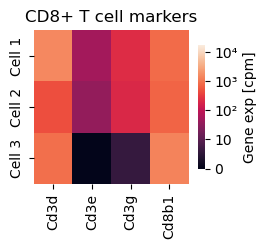

In [127]:
T_marker = ['Cd3d', 'Cd3e', 'Cd3g', 'Cd8b1',]
T_marker_df = pd.DataFrame(adata_primary[show_cell_index, T_marker].X.toarray(),
                           index=['Cell 1', 'Cell 2', 'Cell 3'],
                           columns=T_marker
                          )

fig, ax = plt.subplots(figsize=[2.5, 2])
ax = sns.heatmap(np.log2(T_marker_df), cbar_kws={'label':'Gene exp [cpm]', 'shrink': 0.8,
                                                 }, vmin=0, vmax=14)

ax.collections[0].colorbar.set_ticks(ticks)
ax.collections[0].colorbar.set_ticklabels(['0', '10', '10²', '10³', '10⁴'])

ax.set_title('CD8+ T cell markers')
fig.savefig(save_path + 'T_cell_markers.png', dpi=150,  bbox_inches='tight')

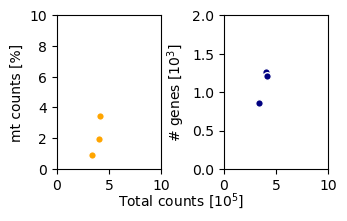

In [126]:
# QC of the antigen presentation dataset
adata_primary = sc.read_h5ad('/home/yike/phd/antigen_presentation/data/atg_ps_raw.h5ad')

adata_primary.var['mt'] = adata_primary.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_primary, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

show_cells = ['G9', 'K9', 'L9']
show_cell_index = adata_primary.obs[(adata_primary.obs['WellName'].isin(show_cells)) & 
                                    (adata_primary.obs['Batch'] == 3)].index

## plotting
fig, axs = plt.subplots(1, 2, figsize=(3.5, 2), sharex=True)
plt.subplots_adjust(wspace=0.6)

axs[0].scatter(x=adata_primary[show_cell_index,:].obs['total_counts']/(10**5), 
               y=adata_primary[show_cell_index,:].obs['pct_counts_mt'], 
               c='orange', edgecolor='white', s=30)

axs[1].scatter(x=adata_primary[show_cell_index,:].obs['total_counts']/(10**5), 
               y=adata_primary[show_cell_index,:].obs['n_genes_by_counts']/(10**3), 
               c='navy', edgecolor='white', s=30)

axs[0].set_ylabel('mt counts [%]')
axs[1].set_ylabel('# genes [$10^3$]')

axs[0].set_ylim([0, 10])
axs[1].set_ylim([0, 2])
axs[0].set_xlim([0, 10])

fig.text(0.48, -0.05, 'Total counts [$10^5$]', va='center', ha='center')

fig.savefig(save_path + 'T_cells_QC.png', dpi=150, bbox_inches='tight')

# Questions related with HyperSeq dataset

## Supplementary HyperSeq pilot experiment

In [5]:
print('load dataset')
fn = '/home/yike/phd/cell_celector/pilot_30_MCF7_cells/data/imaging-sequencing/202106_MCF7_30cells/MiSeq_sequencing/MCF7.h5ad'
adata = sc.read_h5ad(fn)
adata.var_names_make_unique()
sc.pp.normalize_total(adata, target_sum=1e6)

print('Restrict to imaged cells')
letters = ['C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
cellnames_imaged = [i + '5' for i in letters]
cellnames_not = [x for x in adata.obs['picked well'] if x not in cellnames_imaged]
adatai = adata[adata.obs['picked well'].isin(cellnames_imaged)]
adatan = adata[adata.obs['picked well'].isin(cellnames_not)]

load dataset
Restrict to imaged cells


/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
pilot_exp = pd.DataFrame(index=adatai.var_names)
pilot_exp['imaged'] = adatai.X.mean(axis=0)
pilot_exp['not imaged'] = adatan.X.mean(axis=0)

In [7]:
show_genes = adata.var_names[((adatai.X > 0).sum(axis=0) > 3) * ((adatan.X > 0).sum(axis=0) > 3)]

from scipy.stats import spearmanr
rho = spearmanr(pilot_exp.loc[show_genes]['imaged'], pilot_exp.loc[show_genes]['not imaged']).statistic
P = spearmanr(pilot_exp.loc[show_genes]['imaged'], pilot_exp.loc[show_genes]['not imaged']).pvalue

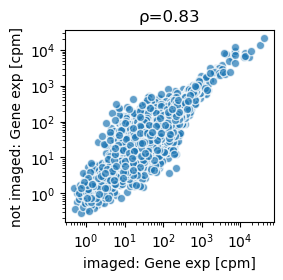

In [8]:
# plotting
fig, ax = plt.subplots(figsize=[2.7, 2.5])

ax.scatter(pilot_exp.loc[show_genes]['imaged'], pilot_exp.loc[show_genes]['not imaged'],
          edgecolor='white', alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('imaged: Gene exp [cpm]')
ax.set_ylabel('not imaged: Gene exp [cpm]')

ax.set_title(f'ρ={round(rho, 2)}')

fig.savefig(save_path + 'Correlation_pilot_imaged_unimaged.png', dpi=150, bbox_inches='tight')

## Make the csv file with counts per gene per cell

In [332]:
if False:
    data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
    adata = sc.read_h5ad(data_fn)
    sc.pp.filter_genes(adata, min_cells=10)

    count_df = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
    count_df.to_csv(save_path + 'HyperSeq_counts.csv', sep=',')

## Others

In [19]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [20]:
# load dataset
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad'
adata = sig_dataset(feas_fn, data_fn)

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]

load features
load dataset
filter genes
Add features to adata


## Comparison with a bulk-seq dataset of MCF-7

In [27]:
'''
1. doi:10.1016/j.dib.2023.109098
2. Total RNA was isolated from MCF-7 cells treated with vehicle control
(0.1% DMSO), or 10 µM enterolactone for 72 h,
and RNA-seq was performed.
3. Vehicle (0.1% DMSO): MC72_1, MC72_2, MC72_5
4. 10 µM Enterolactone: MEL72_2, MEL72_4, MEL72_5
'''

'\n1. doi:10.1016/j.dib.2023.109098\n2. Total RNA was isolated from MCF-7 cells treated with vehicle control\n(0.1% DMSO), or 10 µM enterolactone for 72 h,\nand RNA-seq was performed.\n3. Vehicle (0.1% DMSO): MC72_1, MC72_2, MC72_5\n4. 10 µM Enterolactone: MEL72_2, MEL72_4, MEL72_5\n'

In [55]:
if False:
    from pyensembl import EnsemblRelease
    ensembl = EnsemblRelease(77)

    bulk_fn = '/home/yike/phd/cancer_cells_img_seq/docs/manuscripts/NAR/202405_1st_Review/GSE216876/Counts_RNA-Seq.xlsx'
    bulk_df = pd.read_excel(bulk_fn, sheet_name='countdata_sampl_name', index_col=0)

    bulk_idx = np.intersect1d(ensembl.gene_ids(), bulk_df.index)
    bulk_df['Gene_name'] = 'no'
    for i in bulk_idx:
        bulk_df.loc[i, 'Gene_name'] = ensembl.gene_name_of_gene_id(i)

    bulk_df.to_excel(bulk_fn, sheet_name='countdata_sampl_name')
    
    # I average gene expression of the whole dataset after normalization
    HyperSeq_bulk = pd.DataFrame(adata.X.sum(axis=0), index=adata.var_names, columns=['cpm'])
    HyperSeq_bulk.to_csv('/home/yike/phd/cancer_cells_img_seq/docs/manuscripts/NAR/202405_1st_Review/GSE216876/Counts_HyperSeq.csv', sep=',')

In [9]:
bulk_fn = '/home/yike/phd/cancer_cells_img_seq/docs/manuscripts/NAR/202405_1st_Review/GSE216876/Counts_RNA-Seq.xlsx'
bulk_df = pd.read_excel(bulk_fn, sheet_name='countdata_sampl_name', index_col='Gene_name').drop('Geneid', axis=1)

HyperSeq_fn = '/home/yike/phd/cancer_cells_img_seq/docs/manuscripts/NAR/202405_1st_Review/GSE216876/Counts_HyperSeq.csv'
HyperSeq_bulk = pd.read_csv(HyperSeq_fn, sep=',', index_col=0)

In [10]:
com_genes = list(set(bulk_df.index) & set(HyperSeq_bulk.index))
print(f'The MCF-7 bulk data has {(bulk_df.sum(axis=1) != 0).sum()} gens')
print(f'HyperSeq data has {(HyperSeq_bulk.cpm != 0).sum()} genes')
print(f'{len(com_genes)} were detected from both datasets')

The MCF-7 bulk data has 32851 gens
HyperSeq data has 12873 genes
12836 were detected from both datasets


In [11]:
bulk_norm = bulk_df.loc[com_genes] / bulk_df.loc[com_genes].sum(axis=0) * 1e6
HyperSeq_norm = HyperSeq_bulk.loc[com_genes] / HyperSeq_bulk.loc[com_genes].sum() * 1e6

In [12]:
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

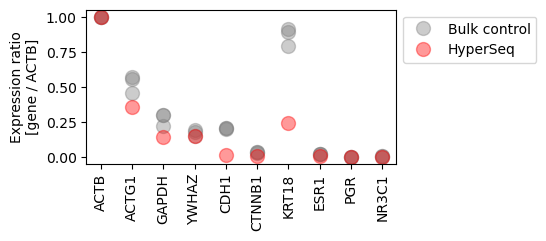

In [15]:
# house keeping genes: ACTB, ACTG1, GAPDH, YWHAZ
# marker genes: CDH1, KRT18, ESR1, PGR, NR3C1
# no VIM, ACTA1, ACTA2 expression in both datasets

# only show MCF-7 control cells treated by DMSO

genes = ['ACTB', 'ACTG1', 'GAPDH', 'YWHAZ', 'CDH1', 'CTNNB1', 'KRT18', 'ESR1', 'PGR', 'NR3C1']
fig, ax = plt.subplots(figsize=[4, 2])
for i, gene in enumerate(genes):
    ax.scatter([i] * 3, (bulk_norm[bulk_norm.columns[:3]].loc[gene] / bulk_norm[bulk_norm.columns[:3]].loc['ACTB']).tolist(), 
               c='gray', alpha=0.4, s=100)
    ax.scatter([i], HyperSeq_norm.loc[gene] / HyperSeq_norm.loc['ACTB'], 
               c='red', alpha=0.4, s=100)
ax.set_xticks(range(len(genes)), genes, rotation=90)
ax.set_ylabel('Expression ratio\n[gene / ACTB]')

handles = []
for color, label in zip(['gray', 'Red'], ['Bulk control', 'HyperSeq']):
    handles.append(Line2D([0], [0], label=label, marker='o', markersize=10, 
                          color=color, alpha=0.4, linestyle='none'))
ax.legend(handles=handles, bbox_to_anchor=[1, 1])

plt.savefig(save_path + 'Bulk_control_vs_HyperSeq.png', bbox_inches='tight', dpi=150)

In [21]:
# house keeping genes: ACTB, ACTG1, GAPDH, YWHAZ
'''
Commonly used housekeeping genes in Q-RT-PCR include beta actin (ACTB), 
glyceraldeyde-3-phosphate dehydrogenase (GAPDH), 
ribosome small subunit (18S) ribsosomal RNA (rRNA), 
Ubiquitin C (UBC), hypoxanthine guanine phosphoribosyl transferase (HPRT), 
succinate dehydrogenase complex, subunit A (SDHA) and 
Tyrosine 3-monooxygenase/tryptophan 5-monooxygenase activation protein, 
zeta polypeptide (YWHAZ) 
# ACTB, ARBP, GAPDH, HPRT, SDHA, UBC, 
'''

'''
MCF-7 cells exhibit features of differentiated mammary epithelium: 
they are positive for epithelial markers, 
such as E-cadherin, β-catenin and cytokeratin 18 (CK18), 
and negative for mesenchymal markers, such as vimentin and smooth muscle actin (SMA)
# CDH1, CTNNB1, KRT18, 
# no VIM, ACTA1, ACTA2
'''

'''
The data set consists of MCF7 which is a human breast cancer cell line with 
estrogen, progesterone and glucocorticoid receptors.
# ESR1, PGR, NR3C1
'''

gene_name
MT-RNR2    17796006.00
MT-CO2      5172216.50
ACTB        4993619.50
MT-CO1      2735806.50
MT-ND4      2677873.50
              ...     
PSMB6        172615.75
HMGB1        171220.20
GFRA1        170753.90
VMP1         167683.56
CSDE1        166459.14
Name: cpm, Length: 100, dtype: float64

## Comparison between alive cells in bacth 1 and bacth 2 

In [21]:
adata_nonlog = sc.read_h5ad('/home/yike/phd/cancer_cells_img_seq/data/combine_gene.h5ad')
adata_nonlog.var['mt'] = adata_nonlog.var_names.str.startswith('MT-')
adata_nonlog.var['rp'] = adata_nonlog.var_names.str.startswith(('RPS', 'RPL'))
sc.pp.calculate_qc_metrics(adata_nonlog, qc_vars=['mt', 'rp'], percent_top=None, log1p=False, inplace=True)

## divide live and dead cells according to the fraction o mitochondrial reads
live_cells = adata_nonlog.obs[adata_nonlog.obs['pct_counts_mt'] < 25].index
dead_cells = adata_nonlog.obs[adata_nonlog.obs['pct_counts_mt'] > 25].index

## dive cells into batch 1 and batch 2
batch2_cells = adata_nonlog.obs_names[adata_nonlog.obs_names.str.contains('3-1')]
batch1_cells = list(set(adata_nonlog.obs_names) - set(batch2_cells))

# live cells in bacth 1 and bacth 2
live1_cells = list(set(batch1_cells) & set(live_cells)) 
live2_cells = list(set(batch2_cells) & set(live_cells))

In [22]:
live1_exp = pd.DataFrame(adata[live1_cells,].X.mean(axis=0), index=adata.var_names, columns=['Gene Exp'])
live1_exp['Exp_cells_n'] = (adata[live1_cells,].X > 0).sum(axis=0)

live2_exp = pd.DataFrame(adata[live2_cells,].X.mean(axis=0), index=adata.var_names, columns=['Gene Exp'])
live2_exp['Exp_cells_n'] = (adata[live2_cells,].X > 0).sum(axis=0)

show_genes = live1_exp.index[(live1_exp['Exp_cells_n'] >= 10) * (live2_exp['Exp_cells_n'] >= 10)]

from scipy.stats import spearmanr
rho = spearmanr(live1_exp.loc[show_genes]['Gene Exp'], live2_exp.loc[show_genes]['Gene Exp']).statistic
P = spearmanr(live1_exp.loc[show_genes]['Gene Exp'], live2_exp.loc[show_genes]['Gene Exp']).pvalue

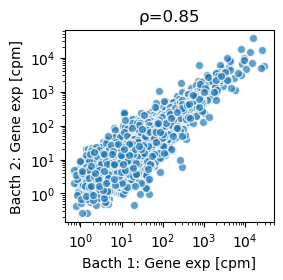

In [23]:
# plotting
fig, ax = plt.subplots(figsize=[2.7, 2.5])

ax.scatter(adata[live1_cells,show_genes].X.mean(axis=0), adata[live2_cells, show_genes].X.mean(axis=0),
          edgecolor='white', alpha=0.7)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Bacth 1: Gene exp [cpm]')
ax.set_ylabel('Bacth 2: Gene exp [cpm]')

ax.set_title(f'ρ={round(rho, 2)}')

fig.savefig(save_path + 'Correlation_live_batch1_vs_2.png', dpi=150, bbox_inches='tight')

## Comparison between ringed vs unringed cells in bacth 1 and bacth 2 

In [34]:
# ringed cells and unringed cells
ring_int_df =  pd.read_csv('/home/yike/phd/cancer_cells_img_seq/figures/seg_rings/' + 'ring_int_df.tsv', sep='\t', index_col=0)
bright_ring_cells = ring_int_df[ring_int_df['Log2FC'] > 0.4].index.tolist() # 60 cells
dim_ring_cells = list(set(adata.obs_names) - set(bright_ring_cells)) # 114 cells

ring_batch1 = list(set(bright_ring_cells) & set(batch1_cells))
unring_batch1 = list(set(dim_ring_cells) & set(batch1_cells))

ring_batch2 = list(set(bright_ring_cells) & set(batch2_cells))
unring_batch2 = list(set(dim_ring_cells) & set(batch2_cells))

# filter genes
save_figures = '/home/yike/phd/cancer_cells_img_seq/docs/hyperspectral_sequencing_ewa/figures/new_batch/Figure2/'

ring_log2fc_df = pd.read_csv(save_figures + 'DEGs_bright_dim/' + 'DEGs_ring_log2fc_signed_ks.tsv', 
                             sep='\t', index_col=0)

In [33]:
## filter genes without median as 0 in both subgroups
filtered_genes_idx = (np.median(adata[bright_ring_cells,].X, axis=0) != 0) * (np.median(adata[dim_ring_cells,].X, axis=0) != 0)
filtered_genes = adata.var_names[filtered_genes_idx] # 2403
ring_log2fc_filtered = ring_log2fc_df.loc[filtered_genes]

## adjust pvalue
from statsmodels.stats.multitest import multipletests
adjust_pvalue = multipletests(ring_log2fc_filtered['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected Benjamini/Hochberg (non-negative)
ring_log2fc_filtered['pvalue_corrected'] = adjust_pvalue

DEGs_idex = ((abs(ring_log2fc_filtered['Log2FC (bright vs blue_dim)']) > 1) * 
             (-np.log10(ring_log2fc_filtered['pvalue_corrected']) > 2))
DEGs_all = ring_log2fc_filtered[DEGs_idex].index.tolist()

In [13]:
ring_cells = {'batch1': ring_batch1, 'batch2': ring_batch2}
unring_cells = {'batch1': unring_batch1, 'batch2': unring_batch2}

if False:
    ring_ks = {}

    from scipy.stats import ks_2samp
    from statsmodels.stats.multitest import multipletests

    for key in ['batch1', 'batch2']:

        df = pd.DataFrame(index = adata.var_names, 
                          columns = ['statistic', 'pvalue', 'statistic_location', 'statistic_sign'])
        for gene in adata.var_names:
            res = ks_2samp(adata[ring_cells[key], gene].X[:,0], adata[unring_cells[key], gene].X[:, 0], 
                        alternative='two-sided', method='asymp')
            df.loc[gene] = [res.statistic, res.pvalue, res.statistic_location, res.statistic_sign]    

        ## log2 fold change
        df[f'Avg_exp ({key}_ring)'] = adata[ring_cells[key], ].X.mean(axis=0)
        df[f'Avg_exp ({key}_unring)'] = adata[unring_cells[key], ].X.mean(axis=0)
        df[f'Log2FC ({key}_ring vs {key}_unring)'] =  np.log2(df[f'Avg_exp ({key}_ring)']+ 1) - np.log2(df[f'Avg_exp ({key}_unring)'] + 1)

        adjust_pvalue = multipletests(df['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected Benjamini/Hochberg (non-negative)
        df['pvalue_corrected (Benjamini/Hochberg)'] = adjust_pvalue

        df.to_csv(save_path + f'DEGs_{key}_ring_vs_unring_signed_ks.tsv', sep='\t')
        ring_ks[key] = df

In [35]:
ring_ks = {}
for key in ['batch1', 'batch2']:
    ring_ks[key] = pd.read_csv(save_path + f'DEGs_{key}_ring_vs_unring_signed_ks.tsv', sep='\t', index_col=0)

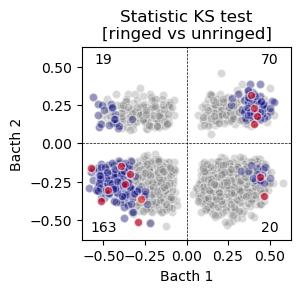

In [43]:
main_figure_genes = [
    'LINC00052', 'LDB1',
    'RANBP2', 'POM121', 'POLR2A', 'POM121C', 'NUP155', 'AGO2',
    'NDUFB11', 
    'COX8A', 'COX7B', 'COX6A1', 'COX6C', 'COX6B1', # are mainly driven by batch 1, right-bottom corner
     ]

fig, ax = plt.subplots(figsize=[2.7, 2.5])

ax.scatter(ring_ks['batch1']['statistic'] * ring_ks['batch1']['statistic_sign'].loc[filtered_genes], 
           ring_ks['batch2']['statistic'] * ring_ks['batch2']['statistic_sign'].loc[filtered_genes],
           c='gray', edgecolor='white', alpha=0.3)

ax.scatter(ring_ks['batch1'].loc[DEGs_all]['statistic'] * ring_ks['batch1'].loc[DEGs_all]['statistic_sign'], 
           ring_ks['batch2'].loc[DEGs_all]['statistic'] * ring_ks['batch2'].loc[DEGs_all]['statistic_sign'],
           c='navy', edgecolor='white', alpha=0.3)

ax.scatter(ring_ks['batch1'].loc[main_figure_genes]['statistic'] * ring_ks['batch1'].loc[main_figure_genes]['statistic_sign'], 
           ring_ks['batch2'].loc[main_figure_genes]['statistic'] * ring_ks['batch2'].loc[main_figure_genes]['statistic_sign'],
           c='red', edgecolor='white', alpha=0.5)

ax.set_xlabel('Bacth 1')
ax.set_ylabel('Bacth 2')

ax.axvline(0, ls='--', c='k', lw=0.5)
ax.axhline(0, ls='--', c='k', lw=0.5)

ax.set_xlim([-0.63, 0.63])
ax.set_ylim([-0.63, 0.63])

ax.set_xticks([-0.5, -0.25, 0, 0.25, 0.5])

ax.set_title('Statistic KS test\n[ringed vs unringed]')

for i in [1, -1]:
    for j in [1, -1]:
        n = ((ring_ks['batch1'].loc[DEGs_all]['statistic_sign'] * i > 0) * 
             (ring_ks['batch2'].loc[DEGs_all]['statistic_sign'] * j > 0)).sum()

        ax.text(0.5 * i, 0.55 * j, str(n), va='center', ha='center')
        
fig.savefig(save_path + 'ringed_vs_unringed_batch_effect.png', 
            dpi=150, bbox_inches='tight')

# we may need rewrite the main manuscript about two COX genes: 'COX6A1', 'COX6C'

## correlations between ringed vs unringed DEGs and different channels

In [359]:
# correlations between spectras and gene expressions at single cell resolution
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
feas = ['{}_{}'.format(col[0], col[1]) for col in df.columns]
corr = get_correlation(adata, feas)
corr = corr.fillna(0)
corr['Frac'] = 100 * (adata[:, corr.index].X > 0).sum(axis=0) / adata.obs.shape[0]
corr['Number'] = (adata[:, corr.index].X > 0).sum(axis=0)

corr.to_csv(save_path + 'spectra_gene_correlation_all_cells.tsv', sep='\t')

/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

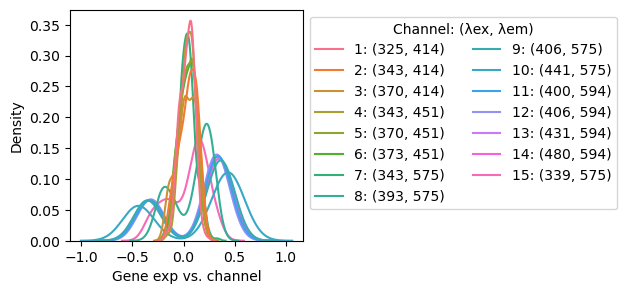

In [415]:
corr_show = corr[corr.columns[:15]]
corr_show.columns = [f'{str(i+1)}: ({wls[:3]}, {wls[-3:]})'
 for i, wls in enumerate(corr_show.columns)]

fig, ax = plt.subplots(figsize=[3, 3])

ax = sns.kdeplot(corr_show.loc[DEGs_all])
# plt.legend(loc='upper center', bbox_to_anchor=(1.05, 1.05), ncol=2, borderaxespad=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), ncol=2, title='Channel: (λex, λem)')

ax.set_xlabel('Gene exp vs. channel')

fig.savefig(save_path + 'Ringed_Gene_vs_channels.png', bbox_inches='tight', dpi=150)

## correlations between ringed vs unringed DEGs and cell size

In [97]:
fd = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/gene/'
corr_size_original = pd.read_csv(fd + 'correlation_live_cells.tsv', sep='\t', index_col=0)
corr_size = corr_size_original.copy()
corr_size['area um2'] = corr_size['area']

In [43]:
corr_size = corr_size[['area um2']].loc[DEGs_all].sort_values('area um2', ascending=False)

corr_size['Rank'] = 0
corr_size.loc[corr_size['area um2'] > 0, 'Rank'] = np.arange((corr_size['area um2'] > 0).sum() + 1)[1:]
corr_size.loc[corr_size['area um2'] < 0, 'Rank'] = (np.arange((corr_size['area um2'] < 0).sum() + 1) * -1)[1:][::-1]

corr_size.to_csv(save_path + 'Rank_size_correlation_DEGs(ringed_vs_unringed).csv', index=',')

In [69]:
# no SNRP genes and no exon splicing junction complex genes(MAGOH, RBM8A, and EIF4A3)
corr_size.index.str.startswith(('SNRP', 'MAGOH', 'RBM8A', 'EIF4A3'))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

## differential exon usage between ringed and unringed cells

In [79]:
fn = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/exon/'

exon_number_frac = pd.read_csv(fn + 'exon_number_frac.tsv', sep='\t', index_col=['gene_name', 'exon_number'])

gene_exp = pd.read_csv(fn + 'gene_exp.tsv', sep='\t', index_col='gene_name')
exon_number_exp = pd.read_csv(fn + 'exon_number_exp.tsv', 
                              sep='\t', index_col=['gene_name', 'exon_number'])

In [80]:
# genes that are not expressed by any cell
no_exp_genes = gene_exp[live_cells][gene_exp[live_cells].sum(axis=1) == 0].index

# genes with only one exon
gene_1exon = [gene for gene in exon_number_exp[live_cells].index.get_level_values(0).unique() 
               if (exon_number_exp[live_cells].loc[gene].sum(axis=1) > 0).sum() == 1]

icld_genes = set(exon_number_frac[live_cells].index.get_level_values(0).unique()) - (set(no_exp_genes) | set(gene_1exon))

In [105]:
genes10 = corr_size_original.index[corr_size_original['Number'] > 10]
idx = list(set(genes10) & set(list(icld_genes)[1:]))
exon_number_frac = exon_number_frac.loc[idx]

In [128]:
exon_df = pd.DataFrame(index=exon_number_frac.index, 
                          columns=['statistic', 'pvalue', 'statistic_location', 'statistic_sign'])
for gene, exon in exon_number_frac.index:
    res = ks_2samp(exon_number_frac[bright_ring_cells].loc[gene, exon].tolist(), 
                   exon_number_frac[dim_ring_cells].loc[gene, exon].tolist(), 
                   alternative='two-sided', method='asymp')
    exon_df.loc[gene, exon] = [res.statistic, res.pvalue, res.statistic_location, res.statistic_sign] 
    
exon_df['Avg_exon_usage_ring'] = exon_number_frac[bright_ring_cells].mean(axis=1)
exon_df['Avg_exon_usage_unring'] = exon_number_frac[dim_ring_cells].mean(axis=1)
exon_df['Log2FC (ring vs unring)'] =  np.log2(exon_df['Avg_exon_usage_ring']+ 0.001) - np.log2(exon_df['Avg_exon_usage_unring'] + 0.001)

adjust_pvalue = multipletests(exon_df['pvalue'], alpha=0.05, method='fdr_bh')[1] # pvals_corrected Benjamini/Hochberg (non-negative)
exon_df['pvalue_corrected (Benjamini/Hochberg)'] = adjust_pvalue

exon_df.to_csv(save_path + 'exon_usage_ringed_vs_unringed.tsv', sep='\t')

In [135]:
exon_df.sort_values('pvalue_corrected (Benjamini/Hochberg)')

statistic    pvalue statistic_location statistic_sign  \
gene_name exon_number                                                         
ADAM15    18           0.503509       0.0           0.003497              1   
NONO      12           0.489474       0.0           0.227593              1   
NUP155    35            0.49386       0.0           0.090883              1   
LTBR      2            0.485088       0.0           0.198171              1   
HNRNPAB   7            0.476316       0.0           0.184722              1   
...                         ...       ...                ...            ...   
ELMO2     1            0.109649  0.695535           0.125486             -1   
          10            0.12193  0.566284           0.142347             -1   
          11           0.102632  0.767875           0.083333             -1   
CEP63     13           0.038596       1.0           0.008704             -1   
ARID4B    9            0.123684  0.548224           0.052125              1   

                       Avg_exon_usage_ring  Avg_exon_usage_unring  \
gene_name exon_number                                               
ADAM15    18                      0.003404               0.019996   
NONO      12                      0.170110               0.227826   
NUP155    35                      0.028044               0.182977   
LTBR      2                       0.199100               0.251739   
HNRNPAB   7                       0.189339               0.280518   
...                                    ...                    ...   
ELMO2     1                       0.076579               0.082503   
          10                      0.132067               0.125167   
          11                      0.024527               0.024090   
CEP63     13                      0.006040               0.003278   
ARID4B    9                       0.095251               0.091667   

                       Log2FC (ring vs unring)  \
gene_name exon_number                            
ADAM15    18                         -2.253064   
NONO      12                         -0.419327   
NUP155    35                         -2.663234   
LTBR      2                          -0.336926   
HNRNPAB   7                          -0.564653   
...                                        ...   
ELMO2     1                          -0.106170   
          10                          0.076824   
          11                          0.024921   
CEP63     13                          0.718505   
ARID4B    9                           0.054757   

                      pvalue_corrected (Benjamini/Hochberg)  
gene_name exon_number                                        
ADAM15    18                                       0.000097  
NONO      12                                       0.000112  
NUP155    35                                       0.000112  
LTBR      2                                        0.000122  
HNRNPAB   7                                        0.000172  
...                                                     ...  
ELMO2     1                                             1.0  
          10                                            1.0  
          11                                            1.0  
CEP63     13                                            1.0  
ARID4B    9                                             1.0  

[86627 rows x 8 columns]

In [187]:
gene_exons = exon_df.sort_values('pvalue_corrected (Benjamini/Hochberg)').index[:5]

violin = exon_number_frac.loc[gene_exons][bright_ring_cells + dim_ring_cells]
violin_show = violin.T.melt(var_name=['Gene name', 'Exon number'], value_name='Exon usage', ignore_index=False)
violin_show['Group'] = 'ringed'
violin_show.loc[violin_show.index.isin(dim_ring_cells), 'Group'] = 'unringed'
violin_show['Gene: Exon number'] = [x + ': ' + str(y) for x, y in zip(violin_show['Gene name'], violin_show['Exon number'])]

,Gene name,Exon number,Exon usage
1-1_C3_S1,ADAM15,18,NaN
1-1_H3_S6,ADAM15,18,0.000000
1-1_I3_S7,ADAM15,18,0.027884
1-1_K3_S9,ADAM15,18,0.000000
1-1_L3_S10,ADAM15,18,0.000000
...,...,...,...
3-1_E12_S111,HNRNPAB,7,0.234096
3-1_M7_S59,HNRNPAB,7,0.224711
3-1_C6_S37,HNRNPAB,7,NaN
3-1_H11_S102,HNRNPAB,7,0.215278


/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/singlecell/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. 

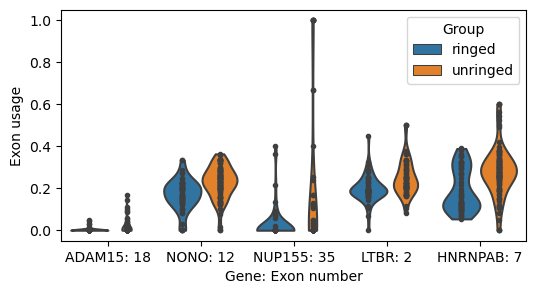

In [211]:
fig, ax = plt.subplots(figsize=[6, 3])
ax = sns.violinplot(x='Gene: Exon number', y='Exon usage', data=violin_show, 
               hue='Group', inner='point', cut=0, density_norm='width')
fig.savefig(save_path + 'top5_ringed_vs_unringed_exon_usage.png', bbox_inches='tight', dpi=300)

In [214]:
exon_df['signed_statistic'] = exon_df['statistic_location'] * exon_df['statistic_sign']

In [217]:
express

statistic    pvalue statistic_location statistic_sign  \
gene_name exon_number                                                         
CTPS2     1             0.07807  0.956435           0.029885              1   
          10           0.037719       1.0            0.05625              1   
          11           0.054386  0.999441            0.03125              1   
          12           0.037719       1.0           0.028571              1   
          13           0.048246  0.999943           0.007663              1   
...                         ...       ...                ...            ...   
ARID4B    5            0.183333  0.127888           0.036681              1   
          6            0.201754  0.072183           0.030975              1   
          7            0.180702  0.138147           0.179913             -1   
          8            0.122807  0.557231            0.43281             -1   
          9            0.123684  0.548224           0.052125              1   

                       Avg_exon_usage_ring  Avg_exon_usage_unring  \
gene_name exon_number                                               
CTPS2     1                       0.044303               0.063344   
          10                      0.022678               0.026210   
          11                      0.010091               0.016297   
          12                      0.014817               0.016567   
          13                      0.006241               0.012148   
...                                    ...                    ...   
ARID4B    5                       0.032554               0.050260   
          6                       0.030202               0.057491   
          7                       0.192482               0.110258   
          8                       0.241924               0.177113   
          9                       0.095251               0.091667   

                       Log2FC (ring vs unring)  \
gene_name exon_number                            
CTPS2     1                          -0.506196   
          10                         -0.200558   
          11                         -0.641158   
          12                         -0.151395   
          13                         -0.860607   
...                                        ...   
ARID4B    5                          -0.611363   
          6                          -0.906561   
          7                           0.798290   
          8                           0.447711   
          9                           0.054757   

                      pvalue_corrected (Benjamini/Hochberg) signed_statistic  
gene_name exon_number                                                         
CTPS2     1                                             1.0         0.029885  
          10                                            1.0          0.05625  
          11                                            1.0          0.03125  
          12                                            1.0         0.028571  
          13                                            1.0         0.007663  
...                                                     ...              ...  
ARID4B    5                                        0.469411         0.036681  
          6                                        0.334942         0.030975  
          7                                        0.491972        -0.179913  
          8                                             1.0         -0.43281  
          9                                             1.0         0.052125  

[86627 rows x 9 columns]